# Silicon Capture in K100

Because of Run 66 we have a flux measurement of our Pu/Be source setup.  It seems that the germanium detector will have too high of a threshold.  However the silicon detector threshold was confirmed to be 18$\,$eV$_{\text{ee}}$, so we will construct the silicon spectrum under these assumptions. 

## Realistic Ionization Yield

[DAMIC][SbBeDAMIC] has made a recent measurement of the ionization yield for low-energy nuclear recoils in silicon.  This prediction seems to indicate values that fall well below the Lindhard prediction at recoil energies below 1$\,$keV.  It is therefore important to take these data into account. 

In that [DAMIC][SbBeDAMIC] publication there are 34 yield points measured and there is a spline fit plotted through them. 

[SbBeDAMIC]: https://journals.aps.org/prd/abstract/10.1103/PhysRevD.94.082007 "DAMIC silicon ionization yield"

I have used [Datathief][Datathief] to extract the points and the X- and Y-error bars.  I have also written a short Python function to read in that data, convert it to ionization yield, fit a spline and plot the result.  See the picture below for the result.  

[Datathief]: http://datathief.org/ "The Datathief program"

<img src="pics/DAMIC_siyield_extrapolate.png" alt="DAMIC silicon ionization yield with spline extrapolation" style="width: 600px;"/>

In [1]:
import damic_y as dy 

#a spline extrapolation to DAMIC data
damic_y = dy.getDAMICy()

dict_keys(['xx', 'yy', 'ex', 'ey'])


In [2]:
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

## Simulated Capture Data

In order to assess the expected signal in a capture experiment that could be run at UMN, I simulated silicon capture cascades in the correct ratios according to the isotopic abundance and probabilities of specific cascades.

I modeled the 47 most important cascades for silicon as accurately as possible.  Information about the capture probabilities has come from [this paper][SiCascade].  Knowledge of the level lifetimes has generally come from [Brookhaven National Lab's interactive chart of the nuclides][nndc].

[SiCascade]: https://journals.aps.org/prc/abstract/10.1103/PhysRevC.46.972 "Si Capture Reference"
[nndc]: https://www.nndc.bnl.gov/chart/ "Interactive Chart of the Nuclides"

Some lifetimes require estimation because they are unknown.  In these cases I use an [empirical relation][WeissCalc] based on the [Weisskopf estimates][WeissEst] for the lifetimes of nuclear states given the multipolarity of their decays.  I often use the shorthand "fast" or "slow" estimates, this means that for a given level I would either use the allowed multipolarity that gives the shortest transition lifetime (fast estimate) or the allowed multipolarity that would give the longest transition time (slow estimates). 

[WeissCalc]: https://www.sciencedirect.com/science/article/pii/S0550306X66800113 "Definition of Weisskopf Units"
[WeissEst]: https://journals.aps.org/pr/abstract/10.1103/PhysRev.83.1073 "Phys. Rev. 1951 Paper of Weisskopf Estimate"

Slow transitions generally result in more well-resolved peaks because the recoiling excited state has time to deposit all of its energy before recoiling off of another gamma.  In that case the sum of the recoil energies is constant in a given cascade.  If any of the decays happen "in flight" then the recoils may not deposit all of their energies and can smear the spectrum.  It is tacitly assumed that all gammas will leave the volume _without_ interacting.  This is a very good approximation for a small detector. 

Let's load up some simulated cascade data. 

In [3]:
import pickle as pkl
lifetimes='fast'

#load up some cascade simulated data; 20k cascade events
with open('/data/chocula/villaa/cascadeSimData/normsi_Quant_{0}.pkl'.format(lifetimes),'rb') as readFile:
      cdata=pkl.load(readFile,encoding='latin1')

print(cdata.keys())

dict_keys(['E', 'cid', 'I', 'Eg', 'totalevents', 'n', 'taus', 'Ei', 'Elev', 'time', 'delE'])


Each of the keys in the associated dictionary is linked to a [NumPy][numpy] data structure with structure and meaning as listed in the table below. 

[numpy]: http://www.numpy.org/ "NumPy"

key name|NumPy structure|Description 
:-|:-|:-
totalevents|integer value|total number of simulated cascades
n|integer array with shape (totalevents,)|number of steps in cascade
cid|integer array with shape (totalevents,)|identifier for specific cascade based on simulation input
Elev|double array with shape (totalevents,n)|level energy after each recoil in keV
taus|double array with shape (totalevents,n)|lifetime of each level in fs
E|double array with shape (totalevents,n)|energy of recoiling ion at the beginning of each "step" in eV
delE|double array with shape (totalevents,n)|energy deposited at each step in eV
I|integer array with shape (totalevents,n)|ionization according to Lindhard model for each step in e/h pairs
Ei|double array with shape (totalevents,n)|effective ionization in electron-equivalent energy for each step in eV$_{ee}$
time|double array with shape (totalevents,n)|absolute time relative to capture time of decay of this step in fs
Eg |double array with shape (totalevents,n)|gamma energy modifying this step's recoil in MeV




We can make a spectrum using the data structure referenced by the key `delE`.  This will be the total deposited energy in the event, accounting for possible in-flight energy modifications as described above.  

### Normalization to g-days

We want to also get the normalization to the absolute rate in g-days.  For this we need to use an estimate for the capture cross section and the volume of the detector with the equation

$$ \huge R_{\text{cap}} = f\Sigma_{\text{cap}}^{Si} V,$$

Where $R_{\text{cap}}$ is the rate of captures, $f$ is the _effective_ thermal flux, $\Sigma_{\text{cap}}^{Si}$ is the macroscopic silicon thermal-neutron capture cross-section, and $V$ is the detector volume.  I have an estimate for the macroscopic cross section in my notebook (N-MISC-17-001 pg 14).  

$$\huge \Sigma_{\text{cap}}^{Si} = \text{0.008572 cm}^{-1} $$

Further, we can assume that the neutron flux is approximately equal to the low end of our desired flux range.

$$\huge f \simeq f_{\text{des}} \sim \text{1}\,\text{n/cm}^{2}\text{s} $$

In [4]:
import numpy as np

#get the true reate
ddet = 10 #10 cm detector diameter
tdet = 3.33 #33 cm thickness
Vol = np.pi*(ddet/2.0)**2*tdet #close to what the volume of detector is
Sig_cap = 0.008572
f = 1 #assume approximate desired flux
rho_si = 2.329 #g/cm^3 approximate r.t. density (what is the change at 50mK?)
Mass=Vol*rho_si
print('detector is {0:1.2f} cm^3'.format(Vol))
print('detector is {0:1.2f} kg'.format(Mass/1000))

#get counts per gram day
cpgd = ((f*Sig_cap*Vol)/(Vol*rho_si))*(24*60*60)
cpkgd = cpgd * 1000

detector is 261.54 cm^3
detector is 0.61 kg


## The Expected Capture Spectrum

Since the capture events consist mostly of composite nuclear recoils, we must decide how to account for the ionization yield correctly for each cascade step.  Assume a nuclear recoil created by a cascade step begins at energy $E_0$ and deposits energy $\delta E$ in the step. We would then expect the ionization to be that which would have been given from a deposited energy of $E_0$ less that which would have been given from a deposit of $E_0 - \delta E$.  This simply assumes that the ionization is independent of the slowing-down history of the particle, or, that any recoil of energy $E$ will give a reproducible amount of ionization regardless of the circumstances of its creation.

In [5]:
#get the summed deposited energy object
Edep = np.sum(cdata['delE'],1)

#Prepare for the computation mentioned above
E = cdata['E']
dE = cdata['delE']
damic_yv = np.vectorize(damic_y) #vectorize it
Eee = E*damic_yv(E) - (E-dE)*damic_yv(E-dE)

In [6]:
eps = 3.8 #eV for silicon
F = 0.1161 #silicon value taken from https://www.sciencedirect.com/science/article/pii/S0168900297009650

#simplistic gaussian model for charge to get width and mean correct
N = np.round(np.random.normal((Eee/eps),np.sqrt(F*(Eee/eps)),np.shape(Eee))) #discretize a normal distribution


#set detector/run parameters
V=100. #Voltage of expected device spectrum
res=40
thresh = 18 #eVee
sigthr = 0.2*thresh #20% ? 
tagg_eff = 1e-2 #tagging efficiency, 1% guess
gesc_eff = 0.9 #for Silicon have about a 10% chance of gammas interacting on the way out

#get the total phonon energy
Et_step = N*V + dE
Et = np.sum(Et_step,1)
Et = Et + np.random.normal(0,res,np.shape(Et)) #add resolution

#convert to eVee scale by making the gamma assumption
evee_scale = (1+(V/eps))
Eee_g = Et/evee_scale

In [7]:
#get histogram
emax = 500 #emax in eV

n,nx = np.histogram(Eee_g,1000,range=(0,emax))

xc = (nx[:-1] + nx[1:]) / 2

#get the event-number and energy normalization
norm = 1/(np.double(cdata['totalevents'])) #normalize per capture
n = np.double(n)/np.diff(nx); #divide by bin width

#normalize
norm*=cpkgd
norm*=tagg_eff
norm*=gesc_eff
n = np.double(n)*norm

Total event rate: 2.86E+03 events/kg-day
Total event rate: 1.74E+03 events/det-day


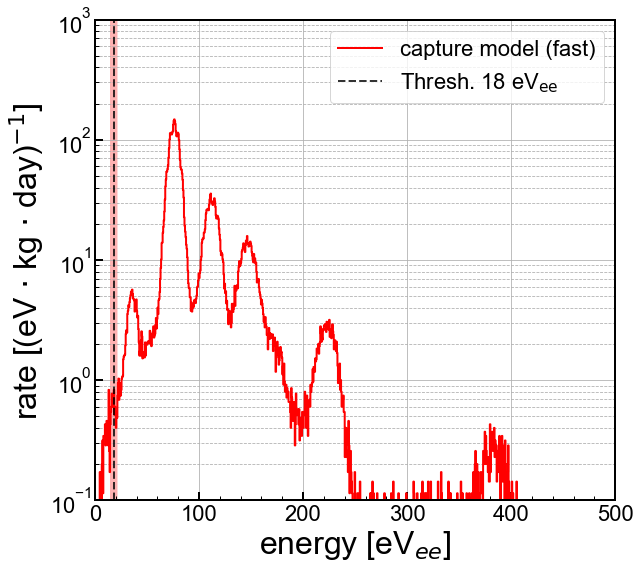

In [8]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


ax1.step(xc,n, where='mid',color='r', linestyle='-', label='capture model ({})'.format(lifetimes), linewidth=2)

print('Total event rate: {0:1.2E} events/kg-day'.format(np.sum(n[xc>18]*np.diff(nx)[xc>18])))
print('Total event rate: {0:1.2E} events/det-day'.format((Mass/1000)*np.sum(n[xc>18]*np.diff(nx)[xc>18])))
ymin = 1e-1
ymax = 1e3

tlabel = 'Thresh. {0} eV$_{{\mathrm{{ee}}}}$'.format(18)
ax1.axvline(thresh, color='k', linestyle='--', lw=2, alpha=0.8,label=tlabel)
erange_x = np.arange(thresh-sigthr, thresh+sigthr, 0.01)
ax1.fill_between(erange_x, ymin, ymax, facecolor='r', alpha=0.3)

ax1.set_yscale('log')
ax1.set_xlim(0, emax) #in pairs
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('energy [eV$_{ee}$]',**axis_font)
ax1.set_ylabel('rate [(eV $\cdot$ kg $\cdot$ day)$^{-1}$]',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/thefigure.eps')
plt.show()

## Events Spectrum

We would like to see what this spectrum looks like if we assume some runtime conditions.  Say if we assume 10 live days of running with the flux used above. 

In [9]:
#get the total number of events expected over exposure of single detector
EvPerDay = (Mass/1000)*np.sum(n[xc>18]*np.diff(nx)[xc>18])
Days=10 #expected exposure length
Ev = EvPerDay*Days

print(np.int(np.round(Ev)))

17401


In [10]:
#restrict spectrum to that number of events
idx = np.arange(np.shape(Eee_g)[0])
idx_rand = np.random.choice(idx,np.int(np.round(Ev)),replace=False)

Eee_g_reduced = Eee_g[idx_rand]
print(np.shape(Eee_g))
print(np.shape(Eee_g_reduced))

(200000,)
(17401,)


In [11]:
#get new histogram
n_red,nx_red = np.histogram(Eee_g_reduced,1000,range=(0,emax))

xc_red = (nx_red[:-1] + nx_red[1:]) / 2

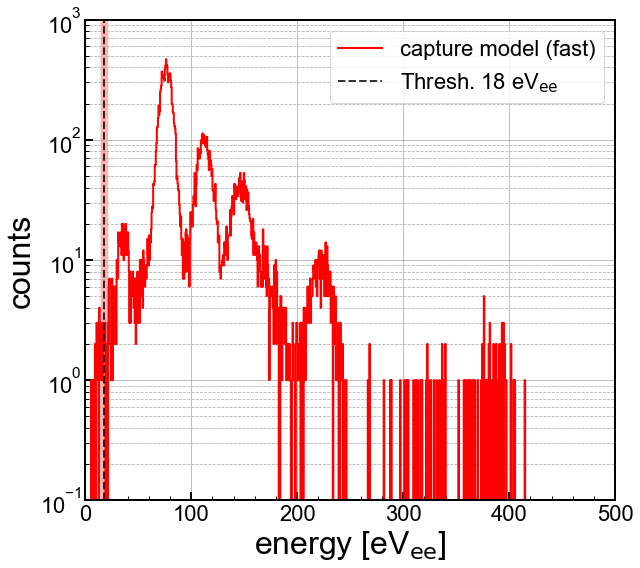

In [12]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


ax1.step(xc_red,n_red, where='mid',color='r', linestyle='-', \
         label='capture model ({})'.format(lifetimes), linewidth=2)

ymin = 1e-1
ymax = 1e3

tlabel = 'Thresh. {0} eV$_{{\mathrm{{ee}}}}$'.format(18)
ax1.axvline(thresh, color='k', linestyle='--', lw=2, alpha=0.8,label=tlabel)
erange_x = np.arange(thresh-sigthr, thresh+sigthr, 0.01)
ax1.fill_between(erange_x, ymin, ymax, facecolor='r', alpha=0.3)

ax1.set_yscale('log')
ax1.set_xlim(0, emax) #in pairs
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('energy [eV$_{\mathrm{ee}}$]',**axis_font)
ax1.set_ylabel('counts',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/SiCapture_1n_per_cm-s_1percent_taggeff.png')
plt.show()